# LSTM forecasting
* https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
A powerful type of neural network designed to handle sequence dependence is called recurrent neural networks. The Long Short-Term Memory network or LSTM network is a type of recurrent neural network used to address time-series prediction problem.<br>
Develop a LSTM network for regression, window and time-step based framing of time series prediction problems.
* https://arxiv.org/abs/1507.06947

The Long Short-Term Memory network, or LSTM network, is a recurrent neural network that is trained using Backpropagation Through Time and overcomes the vanishing gradient problem.<br>
As such, it can be used to create large recurrent networks that in turn can be used to address difficult sequence problems in machine learning and achieve state-of-the-art results.<br>
Instead of neurons, LSTM networks have memory blocks that are connected through layers.<br>
A block has components that make it smarter than a classical neuron and a memory for recent sequences. A block contains gates that manage the block’s state and output. A block operates upon an input sequence and each gate within a block uses the sigmoid activation units to control whether they are triggered or not, making the change of state and addition of information flowing through the block conditional.<br>
There are three types of gates within a unit:
* Forget Gate: conditionally decides what information to throw away from the block.
* Input Gate: conditionally decides which values from the input to update the memory state.
* Output Gate: conditionally decides what to output based on input and the memory of the block.
Each unit is like a mini-state machine where the gates of the units have weights that are learned during the training procedure.

### LSTM Network for Regression
We can phrase the problem as a regression problem.<br>
That is, given the electricity demand this month, what will be the electricity demand next month?

## LSTMs for Univariate Time Series Forecasting
Problem argentina electricity demand prediction problem. This is a problem where, given a year and a month, the task is to predict the argentinian electricity demand in MWh. The data ranges from January 2012 to May 2022, or almost 12 years, with 125 observations.

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import time
from datetime import datetime
from datetime import timedelta

In [4]:
import os

In [5]:
#!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [6]:
# Sólo para cuando se ejecuta desde notebooks:
import warnings
warnings.filterwarnings("ignore", category=Warning)
# Seteos de Pandas para ver mejor la info. https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html
# In max_columns and max_rows ‘None’ value means unlimited.
pd.set_option('display.max_rows', 100)
# Conviene setear min_rows también porque cuando se superan las max_rows, sólo muestra la cantidad indicada en min_rows.
pd.set_option('display.min_rows', 10)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_colwidth = 100
pd.options.display.float_format = '{:.1f}'.format

In [7]:
data_path = r'C:\Users\Usuario\OneDrive\0-Data Science\data_science\pampa\comercial\COM_relevamiento'

In [8]:
df_2012_2014 = pd.read_excel(os.path.join(data_path, 'BASE_INFORME_MENSUAL_2015-12.xlsx'), sheet_name='DEMANDA'
                , header=21, usecols='A:L', decimal=',')
df_2012_2014 = df_2012_2014[df_2012_2014.MES<='2014-12-01']
print(df_2012_2014.shape)
print(df_2012_2014.dtypes)
df_2012_2014.head(3)

(40956, 12)
AÑO                            int64
MES                   datetime64[ns]
AGENTE NEMO                   object
AGENTE DESCRIPCION            object
TIPO AGENTE                   object
REGION                        object
PROVINCIA                     object
CATEGORIA AREA                object
CATEGORIA DEMANDA             object
TARIFA                        object
CATEGORIA TARIFA              object
DEMANDA [MWh]                float64
dtype: object


,AÑO,MES,AGENTE NEMO,AGENTE DESCRIPCION,TIPO AGENTE,REGION,PROVINCIA,CATEGORIA AREA,CATEGORIA DEMANDA,TARIFA,CATEGORIA TARIFA,DEMANDA [MWh]
0,2012,2012-01-01,AARGTAOY,AEROP ARG 2000 - Aeroparque,GU,GRAN BS.AS.,BUENOS AIRES,Gran Usuario MEM,Gran Usuario,GUMAS/AUTOGENERADORES,Industrial/Comercial Grande,2222.6
1,2012,2012-01-01,ACARQQ3Y,ASOC.COOP.ARG. - Quequén,GU,BUENOS AIRES,BUENOS AIRES,Gran Usuario MEM,Gran Usuario,GUMAS/AUTOGENERADORES,Industrial/Comercial Grande,536.9
2,2012,2012-01-01,ACARSLSY,ASOC.COOP.ARG. - San Lorenzo,GU,LITORAL,SANTA FE,Gran Usuario MEM,Gran Usuario,GUMAS/AUTOGENERADORES,Industrial/Comercial Grande,336.3


In [9]:
df_2015_2017 = pd.read_excel(os.path.join(data_path, 'BASE_INFORME_MENSUAL_2018-12.xlsx'), sheet_name='DEMANDA'
                , header=21, usecols='A:L', decimal=',')
df_2015_2017 = df_2015_2017[df_2015_2017.MES<='2017-12-01']
print(df_2015_2017.shape)
print(df_2015_2017.dtypes)
df_2015_2017.head(3)

(41473, 12)
AÑO                            int64
MES                   datetime64[ns]
AGENTE NEMO                   object
AGENTE DESCRIPCION            object
TIPO AGENTE                   object
REGION                        object
PROVINCIA                     object
CATEGORIA AREA                object
CATEGORIA DEMANDA             object
TARIFA                        object
CATEGORIA TARIFA              object
DEMANDA [MWh]                float64
dtype: object


,AÑO,MES,AGENTE NEMO,AGENTE DESCRIPCION,TIPO AGENTE,REGION,PROVINCIA,CATEGORIA AREA,CATEGORIA DEMANDA,TARIFA,CATEGORIA TARIFA,DEMANDA [MWh]
0,2015,2015-01-01,AARGTAOY,AEROP ARG 2000 - Aeroparque,GU,GRAN BS.AS.,BUENOS AIRES,Gran Usuario MEM,Gran Usuario,GUMAS/AUTOGENERADORES,Industrial/Comercial Grande,2098.8
1,2015,2015-01-01,ABRILHCY,ABRIL CLUB DE CAMPO,GU,GRAN BS.AS.,BUENOS AIRES,Gran Usuario MEM,Gran Usuario,GUMAS/AUTOGENERADORES,Industrial/Comercial Grande,1665.9
2,2015,2015-01-01,ACARQQ3Y,ASOC.COOP.ARG. - Quequén,GU,BUENOS AIRES,BUENOS AIRES,Gran Usuario MEM,Gran Usuario,GUMAS/AUTOGENERADORES,Industrial/Comercial Grande,348.7


In [10]:
df_2018 = pd.read_excel(os.path.join(data_path, 'BASE_INFORME_MENSUAL_2019-12.xlsx'), sheet_name='DEMANDA'
                , header=21, usecols='A:L', decimal=',')
df_2018 = df_2018[(df_2018.MES>='2018-01-01') & (df_2018.MES<='2018-12-01')]
print(df_2018.shape)
print(df_2018.dtypes)
df_2018.head(3)

(14304, 12)
AÑO                            int64
MES                   datetime64[ns]
AGENTE NEMO                   object
AGENTE DESCRIPCION            object
TIPO AGENTE                   object
REGION                        object
PROVINCIA                     object
CATEGORIA AREA                object
CATEGORIA DEMANDA             object
TARIFA                        object
CATEGORIA TARIFA              object
DEMANDA [MWh]                float64
dtype: object


,AÑO,MES,AGENTE NEMO,AGENTE DESCRIPCION,TIPO AGENTE,REGION,PROVINCIA,CATEGORIA AREA,CATEGORIA DEMANDA,TARIFA,CATEGORIA TARIFA,DEMANDA [MWh]
27598,2018,2018-01-01,AARGTAOY,AEROP ARG 2000 - Aeroparque,GU,GRAN BS.AS.,BUENOS AIRES,Gran Usuario MEM,Gran Usuario,GUMAS/AUTOGENERADORES,Industrial/Comercial Grande,2038.3
27599,2018,2018-01-01,ABRILHCY,ABRIL CLUB DE CAMPO,GU,GRAN BS.AS.,BUENOS AIRES,Gran Usuario MEM,Gran Usuario,GUMAS/AUTOGENERADORES,Industrial/Comercial Grande,1581.4
27600,2018,2018-01-01,ACARQQ3Y,ASOC.COOP.ARG. - Quequén,GU,BUENOS AIRES,BUENOS AIRES,Gran Usuario MEM,Gran Usuario,GUMAS/AUTOGENERADORES,Industrial/Comercial Grande,343.5


In [11]:
path = r'C:\Users\Usuario\OneDrive\0-Data Science\data_science\pampa\comercial\COM_relevamiento\BASE_INFORME_MENSUAL_2022-05\Bases_Demanda_INFORME_MENSUAL'
df_2019_2022 = pd.read_excel(os.path.join(path, 'Demanda Mensual.xlsx'), sheet_name='DEMANDA'
                , header=23, usecols='A:L', decimal=',')
#df_2019_2022 = df_2019_2022[(df_2019_2022.MES>='2018-01-01') & (df_2019_2022.MES<='2018-12-01')]
print(df_2019_2022.shape)
print(df_2019_2022.dtypes)
df_2019_2022.head(3)

(32619, 12)
AÑO                            int64
MES                   datetime64[ns]
AGENTE NEMO                   object
AGENTE DESCRIPCION            object
TIPO AGENTE                   object
REGION                        object
PROVINCIA                     object
CATEGORIA AREA                object
CATEGORIA DEMANDA             object
TARIFA                        object
CATEGORIA TARIFA              object
DEMANDA [MWh]                float64
dtype: object


,AÑO,MES,AGENTE NEMO,AGENTE DESCRIPCION,TIPO AGENTE,REGION,PROVINCIA,CATEGORIA AREA,CATEGORIA DEMANDA,TARIFA,CATEGORIA TARIFA,DEMANDA [MWh]
0,2019,2019-01-01,AARGTAOY,AEROP ARG 2000 - Aeroparque,GU,GRAN BS.AS.,BUENOS AIRES,Gran Usuario MEM,Gran Usuario,GUMAS/AUTOGENERADORES,Industrial/Comercial Grande,1847.7
1,2019,2019-01-01,ABRILHCY,ABRIL CLUB DE CAMPO,GU,GRAN BS.AS.,BUENOS AIRES,Gran Usuario MEM,Gran Usuario,GUMAS/AUTOGENERADORES,Industrial/Comercial Grande,1394.7
2,2019,2019-01-01,ACARQQ3Y,ASOC.COOP.ARG. - Quequén,GU,BUENOS AIRES,BUENOS AIRES,Gran Usuario MEM,Gran Usuario,GUMAS/AUTOGENERADORES,Industrial/Comercial Grande,489.3


In [12]:
df_hist_detail = pd.concat([df_2012_2014, df_2015_2017, df_2018, df_2019_2022], ignore_index=True)
print(df_hist_detail.shape)
print(df_hist_detail.dtypes)
df_hist_detail.head(3)

(129352, 12)
AÑO                            int64
MES                   datetime64[ns]
AGENTE NEMO                   object
AGENTE DESCRIPCION            object
TIPO AGENTE                   object
REGION                        object
PROVINCIA                     object
CATEGORIA AREA                object
CATEGORIA DEMANDA             object
TARIFA                        object
CATEGORIA TARIFA              object
DEMANDA [MWh]                float64
dtype: object


,AÑO,MES,AGENTE NEMO,AGENTE DESCRIPCION,TIPO AGENTE,REGION,PROVINCIA,CATEGORIA AREA,CATEGORIA DEMANDA,TARIFA,CATEGORIA TARIFA,DEMANDA [MWh]
0,2012,2012-01-01,AARGTAOY,AEROP ARG 2000 - Aeroparque,GU,GRAN BS.AS.,BUENOS AIRES,Gran Usuario MEM,Gran Usuario,GUMAS/AUTOGENERADORES,Industrial/Comercial Grande,2222.6
1,2012,2012-01-01,ACARQQ3Y,ASOC.COOP.ARG. - Quequén,GU,BUENOS AIRES,BUENOS AIRES,Gran Usuario MEM,Gran Usuario,GUMAS/AUTOGENERADORES,Industrial/Comercial Grande,536.9
2,2012,2012-01-01,ACARSLSY,ASOC.COOP.ARG. - San Lorenzo,GU,LITORAL,SANTA FE,Gran Usuario MEM,Gran Usuario,GUMAS/AUTOGENERADORES,Industrial/Comercial Grande,336.3


In [13]:
df_hist_detail.rename(columns={'AÑO': 'year', 'MES': 'month', 'AGENTE MEMO': 'agent_id', 'AGENTE DESCRIPCION': 'agent_desc'
                        , 'TIPO AGENTE': 'agent_type', 'REGION': 'region', 'PROVINCIA': 'province',	'CATEGORIA AREA': 'area_categ'
                        , 'CATEGORIA DEMANDA': 'demand_categ', 'TARIFA': 'rate', 'CATEGORIA TARIFA': 'rate_categ'
                        , 'DEMANDA [MWh]': 'demand_mwh'}, inplace=True)

In [14]:
df_hist = df_hist_detail.groupby('month').agg(monthly_demand_mwh=('demand_mwh', 'sum')).reset_index()
df_hist['monthly_demand_gwh'] = df_hist.monthly_demand_mwh / 1000

In [15]:
df_hist.head()

,month,monthly_demand_mwh,monthly_demand_gwh
0,2012-01-01,10804699.8,10804.7
1,2012-02-01,10085552.2,10085.6
2,2012-03-01,10175365.0,10175.4
3,2012-04-01,8969068.4,8969.1
4,2012-05-01,9597272.0,9597.3


In [16]:
# We are not interested in the date, given that each observation is separated by the same interval of one month. 
# Therefore, when we load the dataset we can exclude the first column.
df_hist_univar = pd.DataFrame(df_hist.monthly_demand_gwh, columns=['monthly_demand_gwh'])
df_hist_univar.head()

,monthly_demand_gwh
0,10804.7
1,10085.6
2,10175.4
3,8969.1
4,9597.3


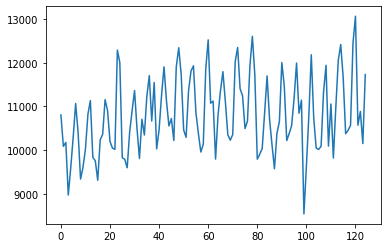

In [17]:
# You can see some trends in the dataset over time.
# You can also see periodicity.
plt.plot(df_hist_univar)
plt.show()

In [18]:
# It is a good idea to fix the random number seed to ensure our results are reproducible.
tf.random.set_seed(786)

In [19]:
# LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. 
# It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. 
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(df_hist_univar)

In [20]:
# Train - Test separation
# With time series data, the sequence of values is important. 
# A simple method that we can use is to split the ordered dataset into train and test datasets. 
# The code below calculates the index of the split point and separates the data into the training datasets 
# with 67% of the observations that we can use to train our model, leaving the remaining 33% for testing the model.

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

83 42


In [21]:
# The LSTM network expects the input data (X) to be provided with a specific array structure 
# in the form of: [samples, time steps, features].
# We can write a simple function to convert our single column of data into a two-column dataset: 
# the first column containing this month’s (t) electricity demand and the second column containing next month’s (t+1) 
# electricity demand, to be predicted.
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

# The function takes two arguments: the dataset, and the look_back, which is the number of previous time steps to use as 
# input variables to predict the next time period — in this case defaulted to 1.
# This will create a dataset where X is the demand at a given time (t) and Y is the demand at the next time (t + 1).

In [22]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [23]:
# Currently, our data is in the form: [samples, features] and we are framing the problem as one time step for each sample. 
# We can transform the prepared train and test input data into the expected structure using numpy.reshape() as follows:
# reshape input to be [samples, time steps, features]
# 1 stands for the time period between data.
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [24]:
# LTSM newtword design
# The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a 
# single value prediction. 
# The default sigmoid activation function is used for the LSTM blocks. 
# The network is trained for 100 epochs and a batch size of 1 is used.

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
81/81 - 4s - loss: 0.2805 - 4s/epoch - 46ms/step
Epoch 2/100
81/81 - 0s - loss: 0.1609 - 129ms/epoch - 2ms/step
Epoch 3/100
81/81 - 0s - loss: 0.0895 - 117ms/epoch - 1ms/step
Epoch 4/100
81/81 - 0s - loss: 0.0518 - 115ms/epoch - 1ms/step
Epoch 5/100
81/81 - 0s - loss: 0.0372 - 105ms/epoch - 1ms/step
Epoch 6/100
81/81 - 0s - loss: 0.0325 - 123ms/epoch - 2ms/step
Epoch 7/100
81/81 - 0s - loss: 0.0312 - 121ms/epoch - 1ms/step
Epoch 8/100
81/81 - 0s - loss: 0.0311 - 114ms/epoch - 1ms/step
Epoch 9/100
81/81 - 0s - loss: 0.0307 - 121ms/epoch - 1ms/step
Epoch 10/100
81/81 - 0s - loss: 0.0305 - 155ms/epoch - 2ms/step
Epoch 11/100
81/81 - 0s - loss: 0.0306 - 143ms/epoch - 2ms/step
Epoch 12/100
81/81 - 0s - loss: 0.0303 - 124ms/epoch - 2ms/step
Epoch 13/100
81/81 - 0s - loss: 0.0301 - 115ms/epoch - 1ms/step
Epoch 14/100
81/81 - 0s - loss: 0.0303 - 111ms/epoch - 1ms/step
Epoch 15/100
81/81 - 0s - loss: 0.0300 - 123ms/epoch - 2ms/step
Epoch 16/100
81/81 - 0s - loss: 0.0295 - 113ms/epoc

In [25]:
# Once the model is fit, we can estimate the performance of the model on the train and test datasets. 
# This will give us a point of comparison for new models.
# Note that we invert the predictions before calculating error scores to ensure that performance is reported in the same units 
# as the original data -pre normalized data.

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions --> to see data on its original scale (pre-normalized)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

2/2 [==============================] - 0s 3ms/step
Train Score: 742.37 RMSE
Test Score: 891.34 RMSE


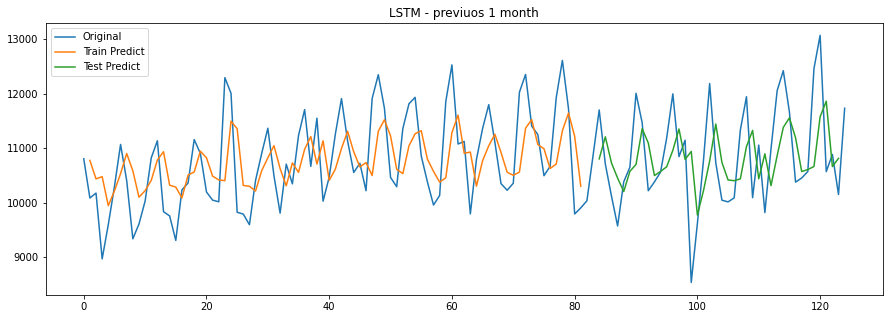

In [30]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(15, 5))
plt.plot(scaler.inverse_transform(dataset), label='Original')
plt.plot(trainPredictPlot, label='Train Predict')
plt.plot(testPredictPlot, label='Test Predict')
plt.title('LSTM - Previuos 1 month')
plt.legend()
plt.show()

Epoch 1/100
80/80 - 2s - loss: 0.2205 - 2s/epoch - 30ms/step
Epoch 2/100
80/80 - 0s - loss: 0.0911 - 187ms/epoch - 2ms/step
Epoch 3/100
80/80 - 0s - loss: 0.0455 - 206ms/epoch - 3ms/step
Epoch 4/100
80/80 - 0s - loss: 0.0365 - 138ms/epoch - 2ms/step
Epoch 5/100
80/80 - 0s - loss: 0.0346 - 160ms/epoch - 2ms/step
Epoch 6/100
80/80 - 0s - loss: 0.0340 - 161ms/epoch - 2ms/step
Epoch 7/100
80/80 - 0s - loss: 0.0331 - 161ms/epoch - 2ms/step
Epoch 8/100
80/80 - 0s - loss: 0.0327 - 165ms/epoch - 2ms/step
Epoch 9/100
80/80 - 0s - loss: 0.0319 - 201ms/epoch - 3ms/step
Epoch 10/100
80/80 - 0s - loss: 0.0316 - 160ms/epoch - 2ms/step
Epoch 11/100
80/80 - 0s - loss: 0.0312 - 173ms/epoch - 2ms/step
Epoch 12/100
80/80 - 0s - loss: 0.0307 - 140ms/epoch - 2ms/step
Epoch 13/100
80/80 - 0s - loss: 0.0304 - 150ms/epoch - 2ms/step
Epoch 14/100
80/80 - 0s - loss: 0.0296 - 164ms/epoch - 2ms/step
Epoch 15/100
80/80 - 0s - loss: 0.0293 - 164ms/epoch - 2ms/step
Epoch 16/100
80/80 - 0s - loss: 0.0290 - 134ms/epoc

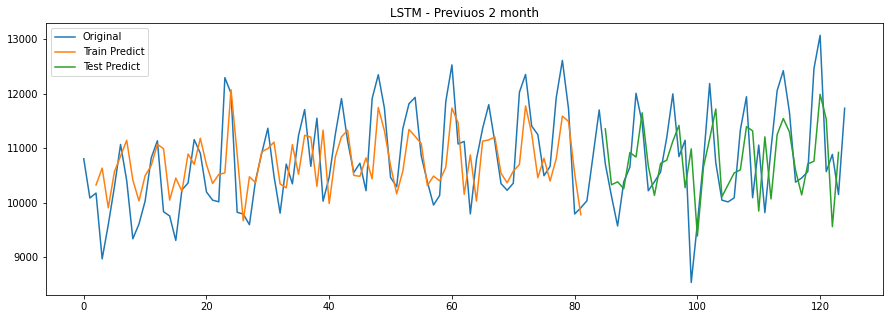

In [32]:
look_back = 2
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions --> to see data on its original scale (pre-normalized)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(15, 5))
plt.plot(scaler.inverse_transform(dataset), label='Original')
plt.plot(trainPredictPlot, label='Train Predict')
plt.plot(testPredictPlot, label='Test Predict')
plt.title('LSTM - Previuos ' + str(look_back) + ' month')
plt.legend()
plt.show()

Epoch 1/100
70/70 - 2s - loss: 0.1539 - 2s/epoch - 27ms/step
Epoch 2/100
70/70 - 0s - loss: 0.0426 - 149ms/epoch - 2ms/step
Epoch 3/100
70/70 - 0s - loss: 0.0324 - 158ms/epoch - 2ms/step
Epoch 4/100
70/70 - 0s - loss: 0.0303 - 140ms/epoch - 2ms/step
Epoch 5/100
70/70 - 0s - loss: 0.0282 - 160ms/epoch - 2ms/step
Epoch 6/100
70/70 - 0s - loss: 0.0254 - 139ms/epoch - 2ms/step
Epoch 7/100
70/70 - 0s - loss: 0.0234 - 158ms/epoch - 2ms/step
Epoch 8/100
70/70 - 0s - loss: 0.0225 - 152ms/epoch - 2ms/step
Epoch 9/100
70/70 - 0s - loss: 0.0202 - 155ms/epoch - 2ms/step
Epoch 10/100
70/70 - 0s - loss: 0.0188 - 141ms/epoch - 2ms/step
Epoch 11/100
70/70 - 0s - loss: 0.0172 - 149ms/epoch - 2ms/step
Epoch 12/100
70/70 - 0s - loss: 0.0167 - 150ms/epoch - 2ms/step
Epoch 13/100
70/70 - 0s - loss: 0.0155 - 146ms/epoch - 2ms/step
Epoch 14/100
70/70 - 0s - loss: 0.0147 - 146ms/epoch - 2ms/step
Epoch 15/100
70/70 - 0s - loss: 0.0140 - 156ms/epoch - 2ms/step
Epoch 16/100
70/70 - 0s - loss: 0.0141 - 154ms/epoc

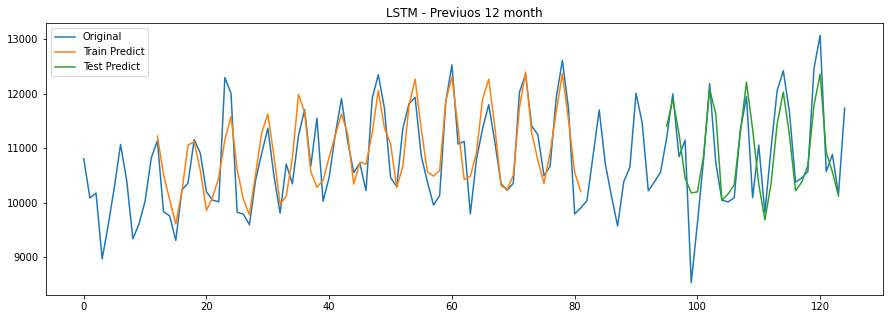

In [33]:
look_back = 12
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions --> to see data on its original scale (pre-normalized)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(15, 5))
plt.plot(scaler.inverse_transform(dataset), label='Original')
plt.plot(trainPredictPlot, label='Train Predict')
plt.plot(testPredictPlot, label='Test Predict')
plt.title('LSTM - Previuos ' + str(look_back) + ' month')
plt.legend()
plt.show()

### Error cuadrático medio (RMSE)
Es la desviación estándar de los valores residuales (errores de predicción). Los valores residuales son una medida de la distancia de los puntos de datos de la línea de regresión; RMSE es una medida de cuál es el nivel de dispersión de estos valores residuales.<br>
_**Medida de disperción de las diferencias entre los valores predichos por un modelo o un estimador y los valores observados.**_

Some researchers have recommended the use of the Mean Absolute Error (MAE) instead of the Root Mean Square Deviation. MAE possesses advantages in interpretability over RMSD. MAE is the average of the absolute values of the errors. MAE is fundamentally easier to understand than the square root of the average of squared errors. Furthermore, each error influences MAE in direct proportion to the absolute value of the error, which is not the case for RMSD.

In [5]:
#data = signals.values
eeg = pd.DataFrame(signals.eeg.astype('float32'), columns=['eeg'])
#signals = signals.astype('float32')
x = signals.timestamp
#normalized_signal = eeg
#N = len(normalized_signal)
# Creo una secuencia de N puntos (el largo de EEG), de 0 hasta el largo de la secuencia en segundos (N/Fs).
#x = np.linspace(0.0, int(N/Fs), N)   
Fs = 128.0
eeg


,eeg
0,21.0
1,20.0
2,20.0
3,22.0
4,22.0
...,...
6425,33.0
6426,40.0
6427,51.0
6428,54.0


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


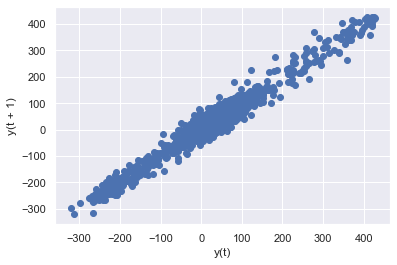

In [ ]:
from pandas.plotting import lag_plot
lag_plot(eeg)
plt.show()

Text(0.5, 1.0, 'EEG Series')

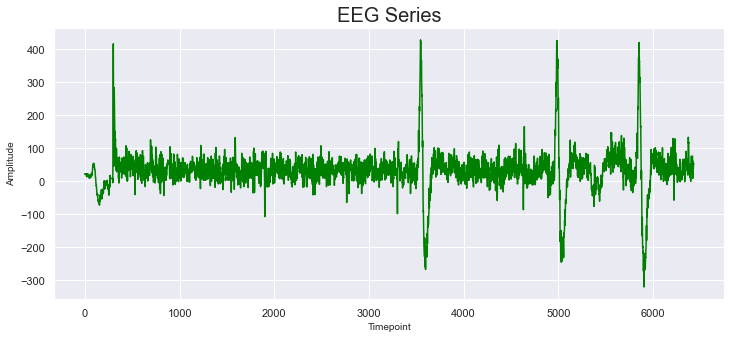

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(eeg,color="green")
plt.ylabel("Amplitude",size=10)
plt.xlabel("Timepoint",size=10)
plt.title("EEG Series",size=20)
plt.show()

In [ ]:
#!pip install tensorflow
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
# fix random seed for reproducibility
np.random.seed(7)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(eeg)
dataset

array([[0.45660883],
       [0.4552737 ],
       [0.4552737 ],
       ...,
       [0.49666223],
       [0.5006676 ],
       [0.49666223]], dtype=float32)

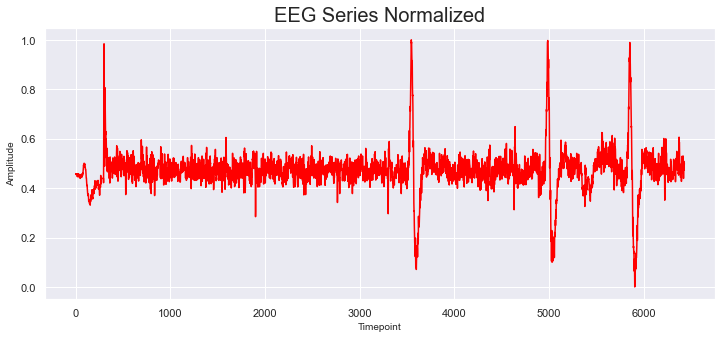

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(dataset, color="red")
plt.ylabel("Amplitude",size=10)
plt.xlabel("Timepoint",size=10)
plt.title("EEG Series Normalized",size=20)
plt.show()

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

4308 2122


In [ ]:
# convert an array of values into a dataset matrix
# If loop_back is 1, we are using t to predict the value t+1
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
4306/4306 - 6s - loss: 0.0050 - 6s/epoch - 1ms/step
Epoch 2/10
4306/4306 - 5s - loss: 5.3922e-04 - 5s/epoch - 1ms/step
Epoch 3/10
4306/4306 - 5s - loss: 4.8689e-04 - 5s/epoch - 1ms/step
Epoch 4/10
4306/4306 - 5s - loss: 4.8212e-04 - 5s/epoch - 1ms/step
Epoch 5/10
4306/4306 - 5s - loss: 4.8261e-04 - 5s/epoch - 1ms/step
Epoch 6/10
4306/4306 - 5s - loss: 4.8336e-04 - 5s/epoch - 1ms/step
Epoch 7/10
4306/4306 - 5s - loss: 4.8444e-04 - 5s/epoch - 1ms/step
Epoch 8/10
4306/4306 - 5s - loss: 4.8491e-04 - 5s/epoch - 1ms/step
Epoch 9/10
4306/4306 - 5s - loss: 4.8352e-04 - 5s/epoch - 1ms/step
Epoch 10/10
4306/4306 - 5s - loss: 4.7962e-04 - 5s/epoch - 1ms/step


In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions-->?????
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

67/67 [==============================] - 0s 1ms/step
Train Score: 17.42 RMSE
Test Score: 18.86 RMSE


In [ ]:
len(testPredict)

2120

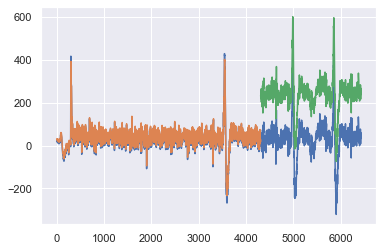

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot+200) # lo sube 200 para poder comparar
plt.show()